In [16]:
!pip install yfinance statsmodels pmdarima matplotlib seaborn scikit-learn

In [1]:

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [18]:
!pip uninstall -y numpy pmdarima
!pip install numpy==1.23.5
!pip install pmdarima

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 92.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.4.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigf

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)


In [10]:
df = yf.download('AAPL', start='2014-01-01', end='2024-12-31')
df.head()


/tmp/ipython-input-10-126565439.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2014-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2014-01-02,17.192822,17.314045,17.158320,17.272083,234684800
2014-01-03,16.815172,17.210544,16.798076,17.184436,392467600
2014-01-06,16.906862,16.996069,16.585777,16.705446,412610800
2014-01-07,16.785950,16.969959,16.720054,16.918984,317209200
2014-01-08,16.892250,16.957523,16.743986,16.747714,258529600


In [11]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df = df.dropna()
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.to_csv('apple_stock_cleaned.csv')

In [12]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['DayOfWeek'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday


In [13]:

df['Return'] = df['Close'].pct_change()

import numpy as np
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))


In [14]:
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

In [15]:

df['Volatility'] = df['Log_Return'].rolling(window=30).std()


In [16]:
df.to_csv('apple_stock_features.csv')


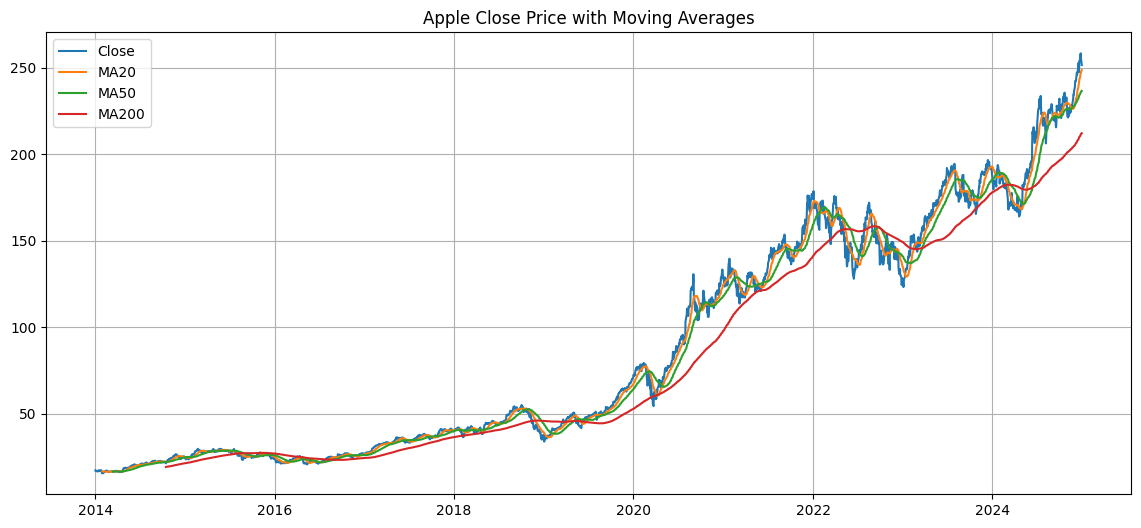

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close')
plt.plot(df['MA20'], label='MA20')
plt.plot(df['MA50'], label='MA50')
plt.plot(df['MA200'], label='MA200')
plt.title("Apple Close Price with Moving Averages")
plt.legend()
plt.grid(True)
plt.show()


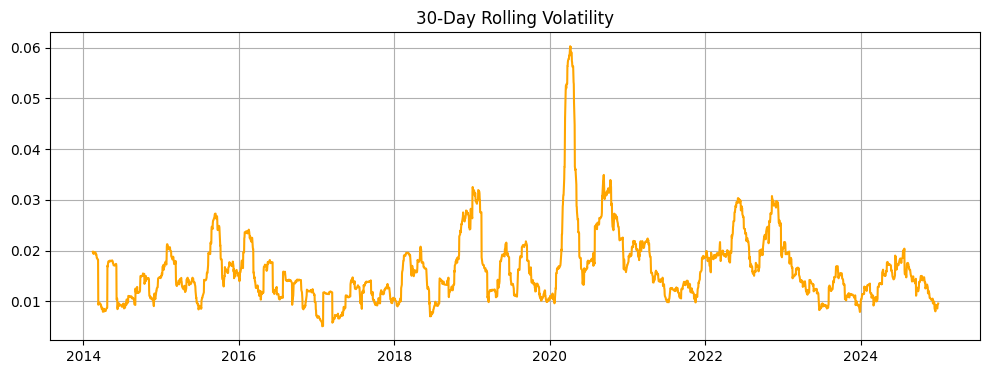

In [18]:
plt.figure(figsize=(12,4))
plt.plot(df['Volatility'], color='orange')
plt.title("30-Day Rolling Volatility")
plt.grid(True)
plt.show()


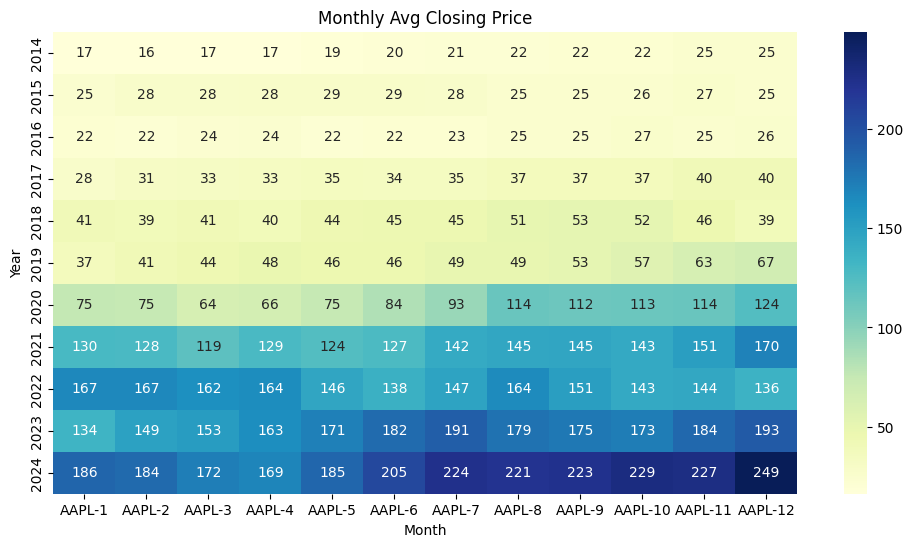

In [19]:
import seaborn as sns

monthly_avg = df['Close'].groupby([df.index.year, df.index.month]).mean().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(monthly_avg, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Monthly Avg Closing Price")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()


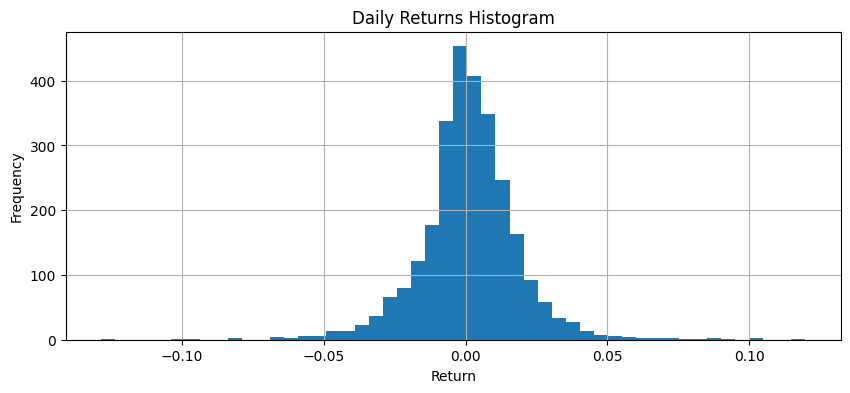

In [20]:
df['Return'].hist(bins=50, figsize=(10,4))
plt.title("Daily Returns Histogram")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [21]:
print(df.index)
print(df.columns)


DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19',
               '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-26',
               '2024-12-27', '2024-12-30'],
              dtype='datetime64[ns]', name='Date', length=2767, freq=None)
MultiIndex([(      'Open', 'AAPL'),
            (      'High', 'AAPL'),
            (       'Low', 'AAPL'),
            (     'Close', 'AAPL'),
            (    'Volume', 'AAPL'),
            (      'Year',     ''),
            (     'Month',     ''),
            (       'Day',     ''),
            ( 'DayOfWeek',     ''),
            (    'Return',     ''),
            ('Log_Return',     ''),
            (      'MA20',     ''),
            (      'MA50',     ''),
            (     'MA200',     ''),
            ('Volatility',     

In [22]:
df.columns = ['_'.join(filter(None, col)).strip() for col in df.columns.values]
df.head()


,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Volume_AAPL,Year,Month,Day,DayOfWeek,Return,Log_Return,MA20,MA50,MA200,Volatility
Date,,,,,,,,,,,,,,,
2014-01-02,17.272083,17.314045,17.158320,17.192822,234684800,2014,1,2,3,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,17.184436,17.210544,16.798076,16.815172,392467600,2014,1,3,4,-0.021966,-0.022210,NaN,NaN,NaN,NaN
2014-01-06,16.705446,16.996069,16.585777,16.906862,412610800,2014,1,6,0,0.005453,0.005438,NaN,NaN,NaN,NaN
2014-01-07,16.918984,16.969959,16.720054,16.785950,317209200,2014,1,7,1,-0.007152,-0.007177,NaN,NaN,NaN,NaN
2014-01-08,16.747714,16.957523,16.743986,16.892250,258529600,2014,1,8,2,0.006333,0.006313,NaN,NaN,NaN,NaN


In [23]:
ts = df['Close_AAPL'].dropna()


In [24]:
df.head()

,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Volume_AAPL,Year,Month,Day,DayOfWeek,Return,Log_Return,MA20,MA50,MA200,Volatility
Date,,,,,,,,,,,,,,,
2014-01-02,17.272083,17.314045,17.158320,17.192822,234684800,2014,1,2,3,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,17.184436,17.210544,16.798076,16.815172,392467600,2014,1,3,4,-0.021966,-0.022210,NaN,NaN,NaN,NaN
2014-01-06,16.705446,16.996069,16.585777,16.906862,412610800,2014,1,6,0,0.005453,0.005438,NaN,NaN,NaN,NaN
2014-01-07,16.918984,16.969959,16.720054,16.785950,317209200,2014,1,7,1,-0.007152,-0.007177,NaN,NaN,NaN,NaN
2014-01-08,16.747714,16.957523,16.743986,16.892250,258529600,2014,1,8,2,0.006333,0.006313,NaN,NaN,NaN,NaN


In [55]:
  from pmdarima import auto_arima

  stepwise_model_sarima = auto_arima(ts,
                                      start_p=1, start_q=1,
                                      max_p=3, max_q=3,
                                      start_P=0, seasonal=True,
                                      m=5,   # 5 trading days per week
                                      d=1, D=1,
                                      trace=True,
                                      error_action='ignore',
                                      suppress_warnings=True,
                                      stepwise=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=4.03 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=13066.870, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[5]             : AIC=12352.564, Time=0.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=2.58 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=13068.066, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[5]             : AIC=12041.119, Time=0.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=8.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=3.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,0)[5]             : AIC=12040.537, Time=0.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[5]             : AIC=12354.008, Time=0.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=5.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,1)[5]             : AIC=inf, Time=1.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,0)[5]             : AIC=12041.072, Time=0.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[5]             : AIC=inf, Time=5.67 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,0)[5] intercept   : AIC=12042.536, Time=2.87 sec

Best model:  ARIMA(0,1,0)(2,1,0)[5]          
Total fit time: 37.218 seconds


In [56]:
n_periods = 30

# If future_dates was lost (from previous ARIMA block), redefine it:
import pandas as pd
future_dates = pd.date_range(start=ts.index[-1], periods=n_periods+1, freq='B')[1:]



In [57]:
forecast_sarima = stepwise_model_sarima.predict(n_periods=n_periods)

# Create forecast DataFrame
forecast_df_sarima = pd.DataFrame({
    'Date': future_dates,
    'SARIMA_Prediction': forecast_sarima
})
forecast_df_sarima.set_index('Date', inplace=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


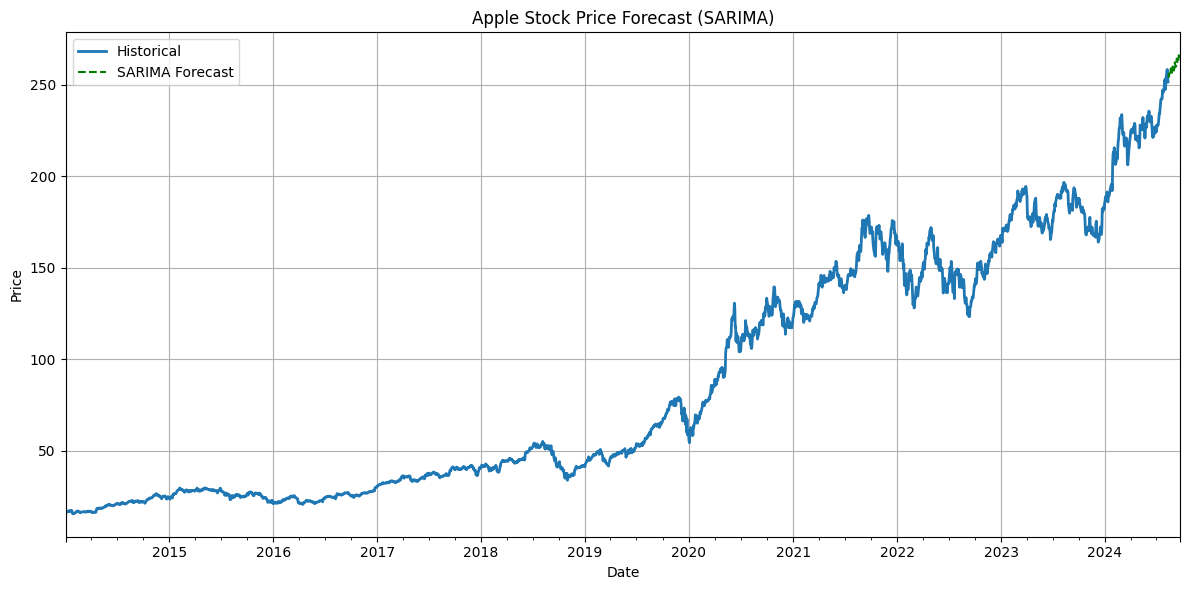

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
ts.plot(label='Historical', linewidth=2)
forecast_df_sarima['SARIMA_Prediction'].plot(label='SARIMA Forecast', linestyle='--', color='green')
plt.title('Apple Stock Price Forecast (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


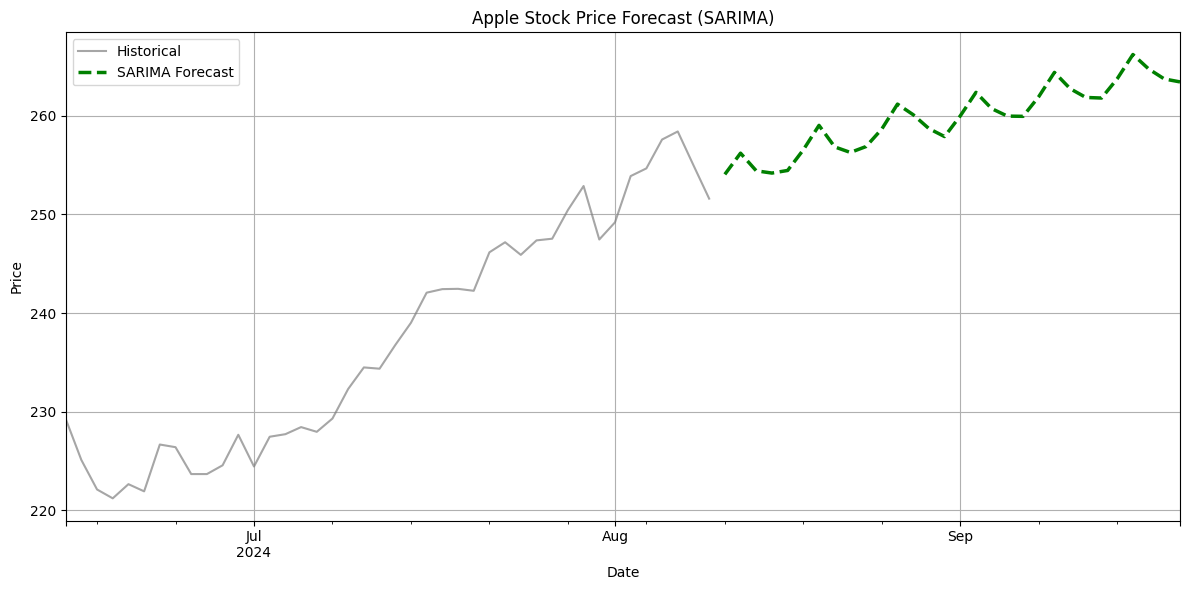

In [60]:
import matplotlib.pyplot as plt
lookback_period = 60
forecast_start = forecast_df_sarima.index[0]
ts_subset = ts[ts.index >= (forecast_start - pd.Timedelta(days=lookback_period))]

plt.figure(figsize=(12,6))

ts_subset.plot(label='Historical', linewidth=1.5, color='gray', alpha=0.7)

forecast_df_sarima['SARIMA_Prediction'].plot(label='SARIMA Forecast', linestyle='--', color='green', linewidth=2.5)

plt.title('Apple Stock Price Forecast (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
from pmdarima import auto_arima

stepwise_model = auto_arima(ts, start_p=1, start_q=1,
                             max_p=3, max_q=3, seasonal=False,
                             trace=True, error_action='ignore',
                             suppress_warnings=True, stepwise=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11219.024, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11217.273, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11218.756, Time=0.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11218.726, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11221.154, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.209 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [62]:
n_periods = 30
forecast_arima = stepwise_model.predict(n_periods=n_periods)

# Create future date range
future_dates = pd.date_range(start=ts.index[-1], periods=n_periods+1, freq='B')[1:]

forecast_df_arima = pd.DataFrame({
    'Date': future_dates,
    'ARIMA_Prediction': forecast_arima
})
forecast_df_arima.set_index('Date', inplace=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


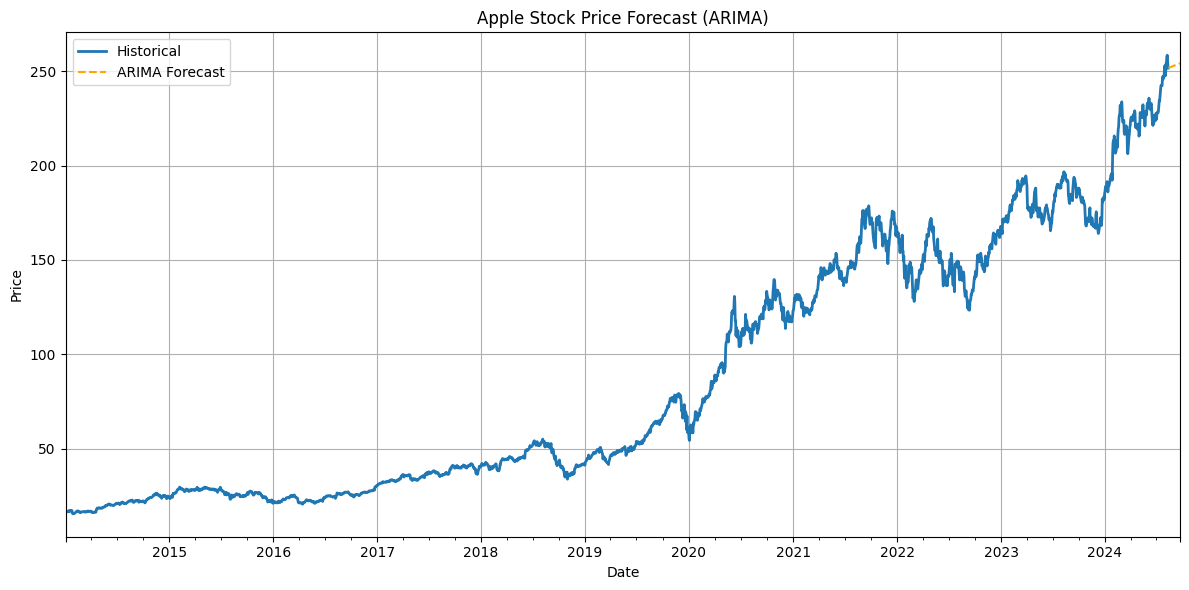

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
ts.plot(label='Historical', linewidth=2)
forecast_df_arima['ARIMA_Prediction'].plot(label='ARIMA Forecast', linestyle='--', color='orange')
plt.title('Apple Stock Price Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


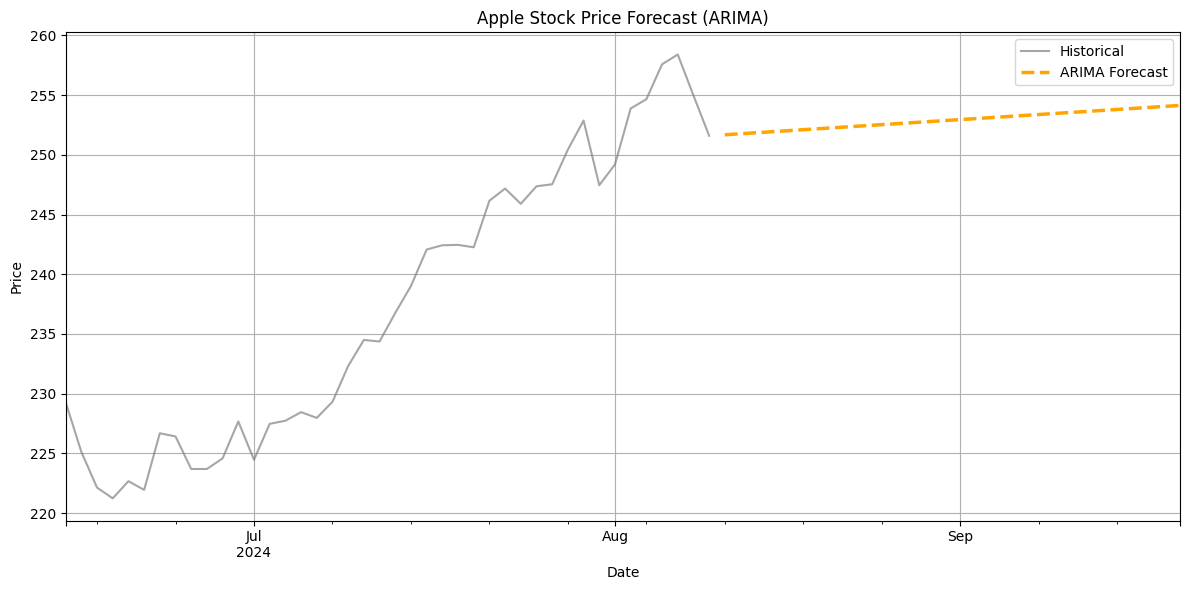

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

lookback_period = 60

forecast_start = forecast_df_arima.index[0]

ts_subset = ts[ts.index >= (forecast_start - pd.Timedelta(days=lookback_period))]

plt.figure(figsize=(12,6))

ts_subset.plot(label='Historical', linewidth=1.5, color='gray', alpha=0.7)

forecast_df_arima['ARIMA_Prediction'].plot(label='ARIMA Forecast', linestyle='--', color='orange', linewidth=2.5)

plt.title('Apple Stock Price Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


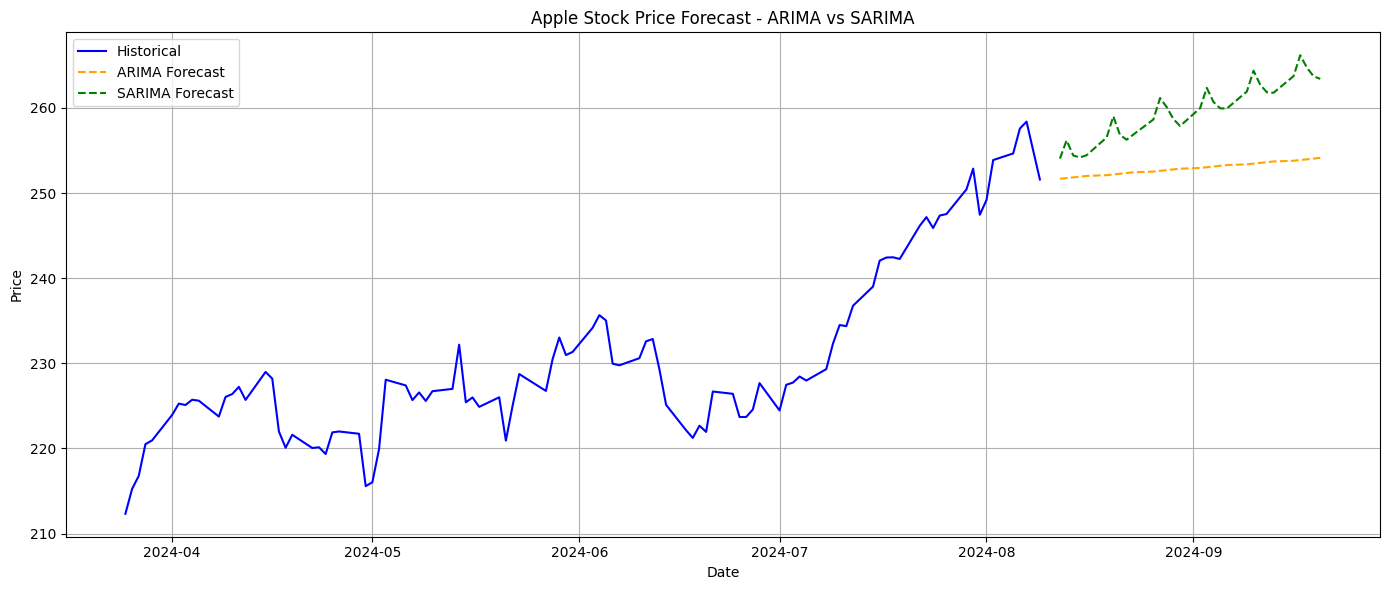

In [65]:
comparison_forecast = forecast_df_arima.join(forecast_df_sarima, how='inner')

plt.figure(figsize=(14,6))
plt.plot(ts[-100:], label='Historical', color='blue')
plt.plot(comparison_forecast['ARIMA_Prediction'], label='ARIMA Forecast', color='orange', linestyle='--')
plt.plot(comparison_forecast['SARIMA_Prediction'], label='SARIMA Forecast', color='green', linestyle='--')

plt.title('Apple Stock Price Forecast - ARIMA vs SARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()